# <b>CS156 (Introduction to AI), Fall 2021</b>
# <u><b>Homework 8 submission</b></u>

### Roster Name: David Danialy
### Student ID: 011187150
### Email address: david.danialy@sjsu.edu
Any special notes or anything you would like to communicate to me about this homework submission goes in here.

##  <u>References and sources </u>

https://www.kaggle.com/grfiv4/plot-a-confusion-matrix

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [146]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import itertools

In [147]:
np.random.seed(42)

#### Code the solution

In [148]:
#Delete corrupted images from training and test sets
num_skipped = 0
class_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
for folder_name in class_labels:
    folder_path = os.path.join("./flowers/training/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)
    folder_path = os.path.join("./flowers/test/", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [149]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training/",
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode='categorical'
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/training/",
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=image_size,
    batch_size=batch_size,
    labels = 'inferred',
    label_mode='categorical'
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/test/",
    seed=42,
    image_size=image_size,
    batch_size=1,
    labels = 'inferred',
    label_mode='categorical'
)

Found 3456 files belonging to 5 classes.
Using 2765 files for training.
Found 3456 files belonging to 5 classes.
Using 691 files for validation.
Found 861 files belonging to 5 classes.


In [150]:
#Define data augmentation layers
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

In [151]:
train_ds_buffer = train_ds.prefetch(buffer_size=32)
val_ds_buffer = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=5)
#model.summary()

In [152]:
#Train the model
epochs = 20
# callbacks = [
#     keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
# ]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds_buffer, epochs=epochs, validation_data=val_ds_buffer,
)

Epoch 1/20
87/87 [==============================] - 13s 136ms/step - loss: 1.3020 - accuracy: 0.5096 - val_loss: 1.6182 - val_accuracy: 0.2590
Epoch 2/20
87/87 [==============================] - 12s 133ms/step - loss: 0.9868 - accuracy: 0.6329 - val_loss: 1.8613 - val_accuracy: 0.2590
Epoch 3/20
87/87 [==============================] - 12s 135ms/step - loss: 0.8662 - accuracy: 0.6741 - val_loss: 2.4486 - val_accuracy: 0.2590
Epoch 4/20
87/87 [==============================] - 12s 136ms/step - loss: 0.8198 - accuracy: 0.7005 - val_loss: 3.1594 - val_accuracy: 0.2590
Epoch 5/20
87/87 [==============================] - 12s 132ms/step - loss: 0.7714 - accuracy: 0.7183 - val_loss: 3.1574 - val_accuracy: 0.2590
Epoch 6/20
87/87 [==============================] - 12s 135ms/step - loss: 0.7413 - accuracy: 0.7244 - val_loss: 1.9191 - val_accuracy: 0.3517
Epoch 7/20
87/87 [==============================] - 11s 131ms/step - loss: 0.6971 - accuracy: 0.7414 - val_loss: 1.1070 - val_accuracy: 0.6281

In [153]:
#Make predictions on the test data
predicted_labels = []
true_labels = []
for x, y in test_ds:
    prediction = model.predict(x)[0].tolist()
    predicted_labels.append(prediction.index(max(prediction)))
    y_temp = y.numpy()[0].tolist()
    true_labels.append(y_temp.index(max(y_temp)))

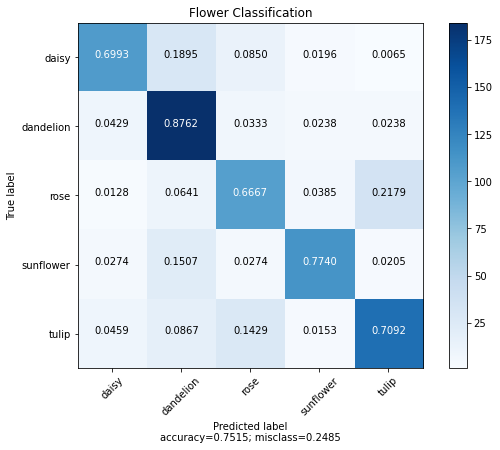

In [154]:
#Plot the confusion matrix, source: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
cm = tf.math.confusion_matrix(labels=true_labels, predictions=predicted_labels).numpy() 
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                        horizontalalignment="center",
                        color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

plot_confusion_matrix(cm, class_labels, title='Flower Classification')

Found 861 files belonging to 5 classes.


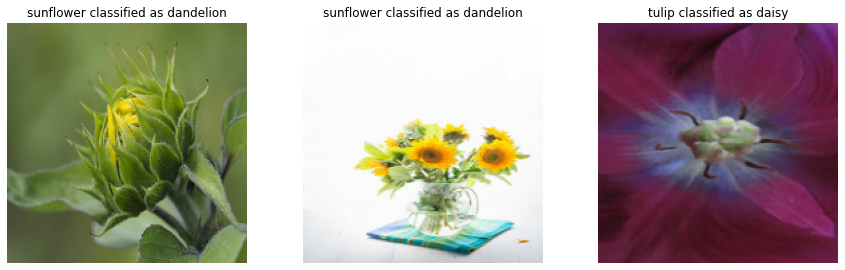

In [156]:
#Reset the dataset iterator
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "./flowers/test/",
    seed=42,
    image_size=image_size,
    batch_size=1,
    labels = 'inferred',
    label_mode='categorical'
)

#Find the first 3 wrongly classified images
count = []
i = 0
while (len(count)) < 3:
    if predicted_labels[i] != true_labels[i]:
        count.append(i)
    i += 1
    
#Get the list of images including all 3 wrongly classified ones
images = list(test_ds.take(5))
fig = plt.figure(figsize=(15, 15))
for i in range(len(count)):
    fig.add_subplot(3, 3, i + 1)
    plt.imshow(images[count[i]][0][0].numpy().astype("uint8"))
    plt.title(class_labels[true_labels[count[i]]] + ' classified as ' + class_labels[predicted_labels[count[i]]])
    plt.axis("off")